In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
root_path = "/content/drive/My Drive/Varuna Hackathon 2022"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "$root_path"

 Grid_AOI	       sentinel-2-image   training_area
'Presentation Slide'   testing_area


In [ ]:
!pip install rasterio
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 422 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 9.5 MB/s 
     |████████████████████████████████| 6.3 MB 49.8 MB/s 
     |████████████████████████████████| 16.7 MB 518 kB/s 


In [ ]:
import rasterio
import rasterio.mask
from rasterio.features import rasterize
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from rasterio import plot

from tqdm import tqdm
from datetime import datetime

import cv2
from skimage import io

In [ ]:
path_2021 = f'{root_path}/sentinel-2-image/2021'
path_2020 = f'{root_path}/sentinel-2-image/2020'

In [ ]:
def read_band(year_path, date, band_name):
    date_path = f'{year_path}/{date}'
    band_path = f'{date_path}/IMG_DATA/47PQS_{date}_{band_name}.jp2'
    band = rasterio.open(band_path)
    return band

In [ ]:
train_shape = gpd.read_file(f'{root_path}/training_area/traindata.shp')
test_shape = gpd.read_file(f'{root_path}/testing_area/testdata.shp')

train_crs = train_shape.to_crs({'init': 'epsg:32647'})
test_crs = test_shape.to_crs({'init': 'epsg:32647'})

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
dates_2021 = ["20210101", "20210106", "20210111", "20210116", "20210121", "20210126", "20210205", "20210210", "20210215", "20210220", "20210225", "20210302", "20210307", "20210312", "20210317", "20210322", "20210327", "20210401", "20210406", "20210411", "20210416", "20210421", "20210426", "20210501", "20210506", "20210511", "20210516", "20210521", "20210526", "20210531", "20210605", "20210610", "20210615", "20210620", "20210625", "20210630", "20210705", "20210710", "20210715", "20210720", "20210725", "20210730", "20210804", "20210809", "20210814", "20210819", "20210824", "20210829", "20210903", "20210908", "20210913", "20210918", "20210923", "20210928", "20211003", "20211008", "20211013", "20211018", "20211023", "20211028", "20211102", "20211107", "20211117", "20211122", "20211127", "20211202", "20211207", "20211212", "20211217", "20211222", "20211227"]
print(len(dates_2021))

71


In [ ]:
def save_tiff(filename, bands):
    with rasterio.open(f'{filename}.tiff','w',driver='Gtiff', width=bands[0].width, height=bands[0].height, 
              count=len(bands),crs=bands[0].crs,transform=bands[0].transform, dtype=bands[0].dtypes[0]) as tiff_file:
        for i in range(1, len(bands)+1):
            tiff_file.write(bands[i].read(1), i)
        tiff_file.close()

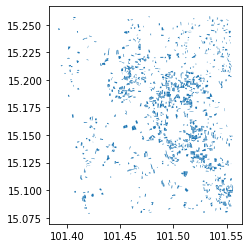

In [ ]:
train_shape = train_shape.to_crs("EPSG:4326")
train_shape.geometry.plot()

In [ ]:
def create_ndvi(date):
    band8 = read_band(path_2021, date, 'B08').read(1).astype(float)
    band4 = read_band(path_2021, date, 'B04').read(1).astype(float)
    NDVI = (band8 - band4) / (band8 + band4)
    return NDVI

def create_savi(date):
    band8 = read_band(path_2021, date, 'B08').read(1).astype(float)
    band4 = read_band(path_2021, date, 'B04').read(1).astype(float)
    SAVI = (band8 - band4) / (band8 + band4 + 0.428) * (1.428)
    return SAVI

def create_ndwi(date):
    band8 = read_band(path_2021, date, 'B08').read(1).astype(float)
    band3 = read_band(path_2021, date, 'B03').read(1).astype(float)
    NDWI = (band3 - band8) / (band3 + band8)
    return NDWI

def create_evi(date):
    band8 = read_band(path_2021, date, 'B08').read(1).astype(float)
    band4 = read_band(path_2021, date, 'B04').read(1).astype(float)
    band2 = read_band(path_2021, date, 'B02').read(1).astype(float)
    EVI = 2.5 * (band8 - band4)/((band8 + (6 * band4) - (7.5 * band2))+1)
    return EVI

def create_misra(date):
    band8 = read_band(path_2021, date, 'B08').read(1).astype(float)
    band6 = read_band(path_2021, date, 'B06').read(1).astype(float)
    band6 = cv2.resize(band6, (2051, 2051), interpolation = cv2.INTER_NEAREST)
    band4 = read_band(path_2021, date, 'B04').read(1).astype(float)
    band3 = read_band(path_2021, date, 'B03').read(1).astype(float)
    Misra = 0.723 * band3 - 0.597 * band4 + 0.206 * band6 - 0.278 * band8
    return Misra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


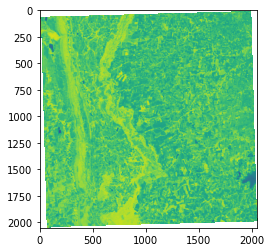

In [ ]:
ndvi_img = create_ndvi(dates_2021[0])
plot.show(ndvi_img)

In [ ]:
img_profile = read_band(path_2021, dates_2021[0], 'B02').profile
train_label = train_shape.to_crs(img_profile['crs'])
test_label = test_shape.to_crs(img_profile['crs'])

In [ ]:
def create_band(date, band_number):
    band = read_band(path_2021, date, band_number).read(1)
    band_resized = cv2.resize(band, (2051, 2051), interpolation = cv2.INTER_NEAREST)
    return band_resized

In [ ]:
months = [None] * len(dates_2021)
dates = {
    # 'b1': [],
    'b5': [],
    'ndvi': [],
    # 'ndwi': [],
    # 'savi': [],
    # 'evi': [],
    'misra': [],
}

for i, date in tqdm(enumerate(dates_2021)):
    dt = datetime.strptime(date, '%Y%m%d')
    months[i] = dt.month
    # dates['b1'].append(create_band(date, 'B01'))
    dates['b5'].append(create_band(date, 'B05'))
    dates['ndvi'].append(create_ndvi(date))
    # dates['ndwi'].append(create_ndwi(date))
    # dates['savi'].append(create_savi(date))
    # dates['evi'].append(create_savi(date))
    dates['misra'].append(create_misra(date))

months = np.array(months)
print(months)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
71it [07:06,  6.01s/it]

[ 1  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4  5
  5  5  5  5  5  5  6  6  6  6  6  6  7  7  7  7  7  7  8  8  8  8  8  8
  9  9  9  9  9  9 10 10 10 10 10 10 11 11 11 11 11 12 12 12 12 12 12]


In [ ]:
def composite_max(max_indices, image):
    out = np.zeros((2051, 2051))
    for x in range(2051):
        for y in range(2051):
            out[x, y] = image[max_indices[x, y], x, y]
    return out

In [ ]:
image_max_months = {
    # 'b1': [],
    'b5': [],
    'ndvi': [],
    # 'ndwi': [],
    # 'savi': [],
    # 'evi': [],
    'misra': [],
}

In [ ]:
image_max_months

{'b5': [], 'misra': [], 'ndvi': []}

In [ ]:
for m in tqdm(range(1, 12+1)):
    indexes = np.where(months == m)[0]
    start = indexes[0]
    end = indexes[-1]

    feature_composite_name = 'ndvi' # 'ndvi', 'evi'
    ndvi_image = np.array(dates[feature_composite_name][start:end+1])
    max_indices = np.argmax(ndvi_image, axis=0)
    image_max_months[feature_composite_name].append(composite_max(max_indices, ndvi_image))

    for index_name in ['misra', 'b5']:
        band_image = np.array(dates[index_name][start:end+1])
        image_max_months[index_name].append(composite_max(max_indices, band_image))

100%|██████████| 12/12 [01:23<00:00,  6.98s/it]


In [ ]:
# TRAIN SET

# average_ndvi = np.zeros((train_label.shape[0], len(max_ndvi_months)))
month_features = []

ndvi_images = []
feature_names = ['ndvi', 'misra', 'b5']
# feature_names = ['ndvi', 'ndwi', 'savi', 'b1'] # 'evi'

for i in tqdm(range(train_label.shape[0])):
    img = rasterize(
        shapes=[(train_label.iloc[i].geometry, 1)], # Construct polygon and value tuples
        out_shape=(img_profile['width'], img_profile['height']),
        transform=img_profile['transform'] # This will make every pixel in the target image align correctly with satellite image
    )

    indexes = np.where(img == 1)
    N = len(indexes[0])

    month_feat = {}
    for feature_name in feature_names:
        for m in range(12):
            feat_vals = np.zeros(N)
            for j in range(N):
                feat_vals[j] = image_max_months[feature_name][m][indexes[0][j], indexes[1][j]]
            month_feat[f'{feature_name}_avg_{m+1}'] = np.nanmean(feat_vals)
            month_feat[f'{feature_name}_std_{m+1}'] = np.nanstd(feat_vals)
            month_feat[f'{feature_name}_max_{m+1}'] = np.nanmax(feat_vals)
            month_feat[f'{feature_name}_min_{m+1}'] = np.nanmin(feat_vals)
    month_features.append(month_feat)

# average_ndvi = np.nan_to_num(average_ndvi[:, :, None])

100%|██████████| 1317/1317 [00:44<00:00, 29.59it/s]


In [ ]:
# TEST SET

test_month_features = []

ndvi_images = []

for i in tqdm(range(test_label.shape[0])):
    img = rasterize(
        shapes=[(test_label.iloc[i].geometry, 1)], # Construct polygon and value tuples
        out_shape=(img_profile['width'], img_profile['height']),
        transform=img_profile['transform'] # This will make every pixel in the target image align correctly with satellite image
    )

    indexes = np.where(img == 1)
    N = len(indexes[0])

    month_feat = {}
    for feature_name in feature_names:
        for m in range(12):
            feat_vals = np.zeros(N)
            for j in range(N):
                feat_vals[j] = image_max_months[feature_name][m][indexes[0][j], indexes[1][j]]
            month_feat[f'{feature_name}_avg_{m+1}'] = np.nanmean(feat_vals)
            month_feat[f'{feature_name}_std_{m+1}'] = np.nanstd(feat_vals)
            month_feat[f'{feature_name}_max_{m+1}'] = np.nanmax(feat_vals)
            month_feat[f'{feature_name}_min_{m+1}'] = np.nanmin(feat_vals)
    test_month_features.append(month_feat)

# average_ndvi = np.nan_to_num(average_ndvi[:, :, None])

100%|██████████| 565/565 [00:16<00:00, 33.39it/s]


In [ ]:
df_all = pd.DataFrame(month_features)
df_all

,ndvi_avg_1,ndvi_std_1,ndvi_max_1,ndvi_min_1,ndvi_avg_2,ndvi_std_2,ndvi_max_2,ndvi_min_2,ndvi_avg_3,ndvi_std_3,...,b5_max_10,b5_min_10,b5_avg_11,b5_std_11,b5_max_11,b5_min_11,b5_avg_12,b5_std_12,b5_max_12,b5_min_12
0,0.362654,0.071053,0.577553,0.166265,0.362654,0.071053,0.577553,0.166265,0.173601,0.028314,...,1748.0,899.0,1510.853333,232.963384,2278.0,643.0,3319.880000,597.459844,3756.0,1710.0
1,0.305288,0.073008,0.569094,0.226119,0.305288,0.073008,0.569094,0.226119,0.283975,0.029603,...,2559.0,1400.0,2289.415385,422.435134,2996.0,1177.0,2337.192308,392.915789,2783.0,1273.0
2,0.435967,0.130793,0.697862,0.246769,0.435967,0.130793,0.697862,0.246769,0.268968,0.064795,...,2132.0,1307.0,1012.100000,257.338372,1580.0,455.0,1265.611905,384.454895,2279.0,798.0
3,0.411076,0.103376,0.700456,0.262450,0.411076,0.103376,0.700456,0.262450,0.379986,0.087642,...,2035.0,1555.0,1004.511905,384.714999,1470.0,451.0,1733.345238,222.536647,2294.0,1400.0
4,0.449940,0.116193,0.676429,0.188548,0.449940,0.116193,0.676429,0.188548,0.430359,0.112723,...,3568.0,842.0,1411.600000,227.893233,1988.0,649.0,1459.835714,399.062090,2810.0,324.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,0.495934,0.070735,0.743562,0.352560,0.495934,0.070735,0.743562,0.352560,0.430522,0.084240,...,1284.0,667.0,1689.290155,168.437897,1989.0,1115.0,1726.072539,141.334810,1952.0,1139.0
1313,0.364318,0.021039,0.410750,0.299737,0.364318,0.021039,0.410750,0.299737,0.352829,0.028747,...,1362.0,483.0,1540.529412,88.282157,1686.0,1212.0,2225.098039,116.788774,2423.0,2065.0
1314,0.356196,0.059106,0.523591,0.231957,0.356196,0.059106,0.523591,0.231957,0.299553,0.105460,...,3067.0,1581.0,1994.164706,395.204499,2470.0,1013.0,1976.100000,187.650039,2327.0,1485.0
1315,0.396760,0.147018,0.731215,0.162031,0.396760,0.147018,0.731215,0.162031,0.314686,0.115279,...,1053.0,319.0,986.087179,357.731195,1859.0,490.0,1545.558974,302.003584,2745.0,970.0


In [ ]:
df_test = pd.DataFrame(test_month_features)
df_test

,ndvi_avg_1,ndvi_std_1,ndvi_max_1,ndvi_min_1,ndvi_avg_2,ndvi_std_2,ndvi_max_2,ndvi_min_2,ndvi_avg_3,ndvi_std_3,...,b5_max_10,b5_min_10,b5_avg_11,b5_std_11,b5_max_11,b5_min_11,b5_avg_12,b5_std_12,b5_max_12,b5_min_12
0,0.268869,0.063259,0.502312,0.153754,0.268869,0.063259,0.502312,0.153754,0.228865,0.060283,...,2372.0,921.0,1252.993548,285.875373,1661.0,310.0,1486.677419,324.038686,2255.0,622.0
1,0.399943,0.105681,0.625748,0.220420,0.399943,0.105681,0.625748,0.220420,0.511118,0.136401,...,1573.0,900.0,1503.625000,227.146944,2189.0,1078.0,2058.732143,458.514196,2675.0,1139.0
2,0.628231,0.103425,0.765470,0.394097,0.628231,0.103425,0.765470,0.394097,0.441230,0.148391,...,1639.0,1087.0,1209.555556,136.898088,1997.0,1092.0,1388.851852,97.380520,1892.0,1242.0
3,0.305596,0.077591,0.584004,0.214601,0.305596,0.077591,0.584004,0.214601,0.295504,0.073969,...,1199.0,940.0,1122.166667,171.414891,2030.0,936.0,2126.296296,319.600539,2659.0,1228.0
4,0.223054,0.026485,0.297041,0.189001,0.223054,0.026485,0.297041,0.189001,0.216183,0.030883,...,2874.0,1910.0,2234.827957,229.128532,3015.0,1636.0,2152.709677,162.067527,2489.0,1704.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,0.267664,0.087608,0.709287,0.167579,0.267664,0.087608,0.709287,0.167579,0.219265,0.064610,...,1564.0,727.0,2326.346154,609.009015,4452.0,954.0,1480.423077,485.605425,2512.0,488.0
561,0.405509,0.096105,0.781100,0.263794,0.405509,0.096105,0.781100,0.263794,0.367585,0.086824,...,1900.0,859.0,1504.282258,378.170640,2603.0,289.0,1612.544355,294.738098,2641.0,848.0
562,0.228061,0.047609,0.480877,0.178297,0.228061,0.047609,0.480877,0.178297,0.216431,0.044100,...,4773.0,1868.0,2671.226974,682.515132,4039.0,639.0,2771.601974,713.917935,3923.0,562.0
563,0.177394,0.027103,0.285203,0.148498,0.177394,0.027103,0.285203,0.148498,0.158519,0.024606,...,2649.0,1257.0,1820.726415,345.413057,2468.0,799.0,1889.198113,331.853071,2685.0,1329.0


In [ ]:
df_all['crop_type'] = train_shape.crop_type
df_all['years'] = train_shape.years
df_all.to_csv('train_NDVI_misra_b5.csv', index=False)
df_all.head()

,ndvi_avg_1,ndvi_std_1,ndvi_max_1,ndvi_min_1,ndvi_avg_2,ndvi_std_2,ndvi_max_2,ndvi_min_2,ndvi_avg_3,ndvi_std_3,...,b5_avg_11,b5_std_11,b5_max_11,b5_min_11,b5_avg_12,b5_std_12,b5_max_12,b5_min_12,crop_type,years
0,0.362654,0.071053,0.577553,0.166265,0.362654,0.071053,0.577553,0.166265,0.173601,0.028314,...,1510.853333,232.963384,2278.0,643.0,3319.880000,597.459844,3756.0,1710.0,1,2021
1,0.305288,0.073008,0.569094,0.226119,0.305288,0.073008,0.569094,0.226119,0.283975,0.029603,...,2289.415385,422.435134,2996.0,1177.0,2337.192308,392.915789,2783.0,1273.0,1,2021
2,0.435967,0.130793,0.697862,0.246769,0.435967,0.130793,0.697862,0.246769,0.268968,0.064795,...,1012.100000,257.338372,1580.0,455.0,1265.611905,384.454895,2279.0,798.0,1,2021
3,0.411076,0.103376,0.700456,0.262450,0.411076,0.103376,0.700456,0.262450,0.379986,0.087642,...,1004.511905,384.714999,1470.0,451.0,1733.345238,222.536647,2294.0,1400.0,3,2021
4,0.449940,0.116193,0.676429,0.188548,0.449940,0.116193,0.676429,0.188548,0.430359,0.112723,...,1411.600000,227.893233,1988.0,649.0,1459.835714,399.062090,2810.0,324.0,2,2021


In [ ]:
df_test['years'] = train_shape.years
df_test.to_csv('test_NDVI_misra_b5.csv', index=False)
df_test.head()

,ndvi_avg_1,ndvi_std_1,ndvi_max_1,ndvi_min_1,ndvi_avg_2,ndvi_std_2,ndvi_max_2,ndvi_min_2,ndvi_avg_3,ndvi_std_3,...,b5_min_10,b5_avg_11,b5_std_11,b5_max_11,b5_min_11,b5_avg_12,b5_std_12,b5_max_12,b5_min_12,years
0,0.268869,0.063259,0.502312,0.153754,0.268869,0.063259,0.502312,0.153754,0.228865,0.060283,...,921.0,1252.993548,285.875373,1661.0,310.0,1486.677419,324.038686,2255.0,622.0,2021
1,0.399943,0.105681,0.625748,0.220420,0.399943,0.105681,0.625748,0.220420,0.511118,0.136401,...,900.0,1503.625000,227.146944,2189.0,1078.0,2058.732143,458.514196,2675.0,1139.0,2021
2,0.628231,0.103425,0.765470,0.394097,0.628231,0.103425,0.765470,0.394097,0.441230,0.148391,...,1087.0,1209.555556,136.898088,1997.0,1092.0,1388.851852,97.380520,1892.0,1242.0,2021
3,0.305596,0.077591,0.584004,0.214601,0.305596,0.077591,0.584004,0.214601,0.295504,0.073969,...,940.0,1122.166667,171.414891,2030.0,936.0,2126.296296,319.600539,2659.0,1228.0,2021
4,0.223054,0.026485,0.297041,0.189001,0.223054,0.026485,0.297041,0.189001,0.216183,0.030883,...,1910.0,2234.827957,229.128532,3015.0,1636.0,2152.709677,162.067527,2489.0,1704.0,2021


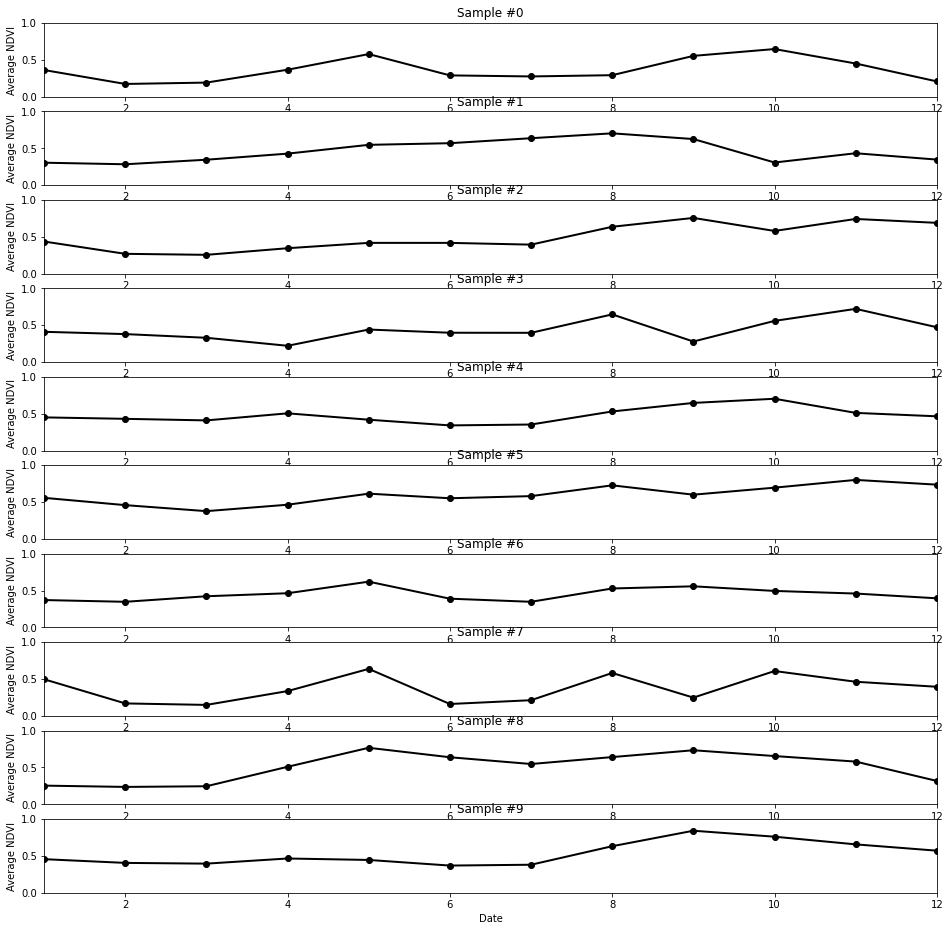

In [ ]:
sample_id = 0
fig, axs = plt.subplots(10, 1, figsize=(16,16))
for sample_id, ax in enumerate(axs):
    ax.plot(list(range(1, 12+1)), average_ndvi[sample_id], '-o', linewidth=2, color='k', markersize=6)
    ax.set_xlim(1, 12)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Average NDVI')
    ax.set_title(f"Sample #{sample_id}")
    plt.grid()
# plt.xticks(rotation=70)
plt.savefig(f'average_NDVI-sample_{sample_id}.png', bbox_inches='tight')
plt.show()

In [ ]:
train_df.groupby('crop_type').mean().to_csv('train_max_ndvi-means.csv')